In [1]:
!python3 -m pip install opencv-python
import sys
import matplotlib.pylab as plt
import cv2
import os 
from os.path import join
import numpy as np
import random as rng
from copy import deepcopy

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
motdata = join(".",'train/MOT17-09/img1/')
sys.path.append(motdata)

./train/MOT17-09/img1/
000001.jpg


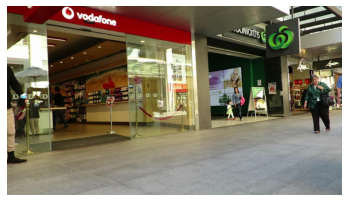

In [3]:
list_motdata = os.listdir(motdata)
list_motdata.sort()
print(motdata)
print(list_motdata[0])

img_ex_path = motdata + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(img_ex)
plt.axis('off')
plt.show()

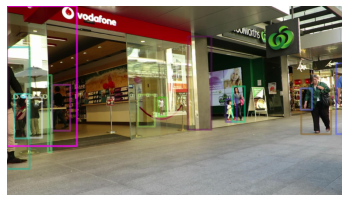

In [4]:
gt = open('./train/MOT17-09/gt/gt.txt', 'r')
frame_gt = []
unsegmented_image = img_ex.copy()

for gt_line in gt:
    frame, bb_id, bb_left, bb_top, bb_width, bb_height, x, y, z = gt_line.split(",")
    frame = int(frame)
    bb_id = int(bb_id)
    bb_left = int(bb_left)
    bb_top = int(bb_top)
    bb_width = int(bb_width)
    bb_height = int(bb_height)
    x = float(x)
    y = float(y)
    z = float(z)
    
    if frame == 1:
        overlay = unsegmented_image.copy()
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        alpha = 0.7
        
        frame_gt.append((bb_left, bb_top, bb_width, bb_height))
        
        pt1=(bb_left,bb_top)
        pt2=(bb_left+bb_width,bb_top+bb_height)
        cv2.rectangle(overlay, pt1 , pt2 , color, thickness = 10)
        unsegmented_image = cv2.addWeighted(overlay, alpha, unsegmented_image, 1 - alpha, 0)
        
# test rectangle
cv2.rectangle(unsegmented_image, (0,0) , (400,  800) , (255,0,255), thickness = 10)
unsegmented_image = cv2.addWeighted(unsegmented_image, alpha, img_ex, 1 - alpha, 0)
        
plt.imshow(unsegmented_image)
plt.axis('off')
plt.show()
#         cv.rectangle(img_ex, (int(boundRect[i][0]), int(boundRect[i][1])), \
#           (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
gt.close()

In [5]:
img_ex.shape
# print(frame_gt)

(1080, 1920, 3)

In [6]:
def getGrid(i, j, y_size, x_size):
    grid_top_left, grid_bottom_right = (int(i * x_size), int(j * y_size)), (int((i+1) * x_size), int((j+1) * y_size))
    tl_point = grid_top_left
    bl_point = (grid_bottom_right[0], grid_top_left[1]) #pink
    tr_point = (grid_top_left[0], grid_bottom_right[1]) #cyan
    br_point = grid_bottom_right
    return (tl_point, bl_point, tr_point, br_point)

def getTLandBR(l, t, w, h):
    tl=(l,t) #x, y
    br=(l+w,t+h)
    return(tl, br)

def isPointInGrid(tl, br, p):
#     print(p[0] <= br[0])
#     print(p[0] >= tl[0])
#     print(p[1] <= br[1])
#     print(p[1] >= tl[1])
#     print()
    if (p[0] <= br[0] and p[0] >= tl[0] and p[1] <= br[1] and p[1] >= tl[1]) :
        return True
    else :
        return False

def segment(frame, gt_bb, new_dim=(2, 2)):
    x_size = frame.shape[0]/new_dim[0]
    y_size = frame.shape[1]/new_dim[1]
    
    new_bb = []
    bb_organized_by_quadrant = [[[] for c in range(new_dim[0])] for r in range(new_dim[1])]
    
    for bb in gt_bb:
        bb_left, bb_top, bb_width, bb_height = bb
        bb_tl, bb_br = getTLandBR(bb_left, bb_top, bb_width, bb_height)
        bb_br = min(bb_br[0], frame.shape[1]), min(bb_br[1], frame.shape[0])
        
        tl_point = bb_tl
        bl_point = (bb_br[0], bb_tl[1]) #pink
        tr_point = (bb_tl[0], bb_br[1]) #cyan
        br_point = bb_br
        
        start_grid = None
        end_grid = None
        for i in range(0, new_dim[0]):
            for j in range(0, new_dim[1]):
                grid_top_left, grid_bottom_left, grid_top_right, grid_bottom_right = getGrid(i, j, x_size, y_size)
#                 print('        ', i, j, y_size, x_size, grid_top_left, grid_bottom_right)
                grid_top_left_y, grid_top_left_x = grid_top_left
                grid_bottom_right_y, grid_bottom_right_x = grid_bottom_right
                
#                 print('    tl_point, (', tl_point, ') br_point, (', br_point, ') grid_top_left (' , grid_top_left, ') grid_bottom_right (' , grid_bottom_right)
#                 print('    tl_point, (', tl_point, ')')
                if (isPointInGrid(grid_top_left, grid_bottom_right, tl_point)):
#                     print ("tl_point (", tl_point, ") belongs in ", start_grid, end_grid)
                    start_grid = grid_top_left
#                 print('    br_point, (', br_point, ')')
                if (isPointInGrid(grid_top_left, grid_bottom_right, br_point)):
#                     print ("br_point (", br_point, ") belongs in ", start_grid, end_grid)
                    end_grid = grid_top_left
        
        ## TODO: normalize all bounding boxes outisde of res size
#         if start_grid == None or end_grid == None:
#             print("start and end box not detected")
            
#             print('    bb tl, br', bb_tl, bb_br)
#             print('    ', start_grid, end_grid)
#         print ("bb (", bb_tl, bb_br, ") belongs in ", start_grid, end_grid)
        
        if start_grid != None and end_grid != None:
            
            if start_grid == end_grid:
                new_bb.append(bb)
#                 print("square start and ends in the same grid")
#                 print("found 1 segments")
            else: 
#                 print("segmenting bb")
                x_units = (end_grid[0] - start_grid[0]) / y_size
                y_units = (end_grid[1] - start_grid[1]) / x_size 
                
                count_segments = 0
                for i in range(0, new_dim[0]):
                    for j in range(0, new_dim[1]):
                        grid_top_left, grid_bottom_left, grid_top_right, grid_bottom_right = getGrid(i, j, x_size, y_size)
                        segmented_bb = None
                        
                        if (isPointInGrid(grid_top_left, grid_bottom_right, tl_point)):
#                             print ("tl_point (", tl_point, ") belongs in ", start_grid, end_grid)
                            segment_bb_in_grid = list(bb_br)
#                             print("tl_point")
#                             print("original: ", segment_bb_in_grid)
                            if (x_units == 0):
                                segment_bb_in_grid[1] = grid_bottom_right[1]
#                                 print("X_change: ", segment_bb_in_grid)
                            if (y_units == 0):
                                segment_bb_in_grid[0] = grid_bottom_right[0]
#                                 print("Y_change: ", segment_bb_in_grid)
                            if (x_units > 0 and y_units > 0):
                                segment_bb_in_grid = grid_bottom_right
#                                 print("both: ", segment_bb_in_grid)
                            segmented_bb = (bb_tl, tuple(segment_bb_in_grid))
                        elif (isPointInGrid(grid_top_left, grid_bottom_right, br_point)):
#                             print ("br_point (", br_point, ") belongs in ", start_grid, end_grid)
                            segment_bb_in_grid = list(bb_tl)
#                             print("br_point")
#                             print("original: ", segment_bb_in_grid)
                            if (x_units == 0):
                                segment_bb_in_grid[1] = grid_top_left[1]
#                                 print("X_change: ", segment_bb_in_grid)
                            if (y_units == 0):
                                segment_bb_in_grid[0] = grid_top_left[0]
#                                 print("Y_change: ", segment_bb_in_grid)
                            if (x_units > 0 and y_units > 0):
                                segment_bb_in_grid = grid_top_left
#                                 print("both: ", segment_bb_in_grid)
                            segmented_bb = (tuple(segment_bb_in_grid),  bb_br)
                        elif (isPointInGrid(grid_top_left, grid_bottom_right, bl_point) and (x_units > 0 or y_units > 0)):
                            print("bottomleft")
                            print((bl_point[0], grid_top_right[1]), (grid_top_right[0], bl_point[1]))
                            segmented_bb = ((bl_point[0], grid_top_right[1]), (grid_top_right[0], bl_point[1]))
                        elif (isPointInGrid(grid_top_left, grid_bottom_right, tr_point) and (x_units > 0 or y_units > 0)):
                            print("topright")
                            print((grid_bottom_left[0], tr_point[1]), (tr_point[0], grid_bottom_left[1]))
                            segmented_bb = ((grid_bottom_left[0], tr_point[1]), (tr_point[0], grid_bottom_left[1]))
                        
                        if (segmented_bb != None):
                            count_segments += 1
                            s_bb_tl = segmented_bb[0]
                            s_bb_br = segmented_bb[1]
                            s_w = s_bb_br[0] - s_bb_tl[0]
                            w_h = s_bb_br[1] - s_bb_tl[1]
                            proper_format = (s_bb_tl[0], s_bb_tl[1], s_w, w_h)
                            new_bb.append(proper_format)
                            
                            bb_organized_by_quadrant[i][j].append(proper_format)
                            
#                         else:
#                             print("Skip, bb does not belong here")
#                             print ("bb (", bb_tl, bb_br, ") with start and end: ", start_grid, end_grid)
#                             print (x_units, y_units, )
#                             print (grid_top_left, grid_bottom_right)
#                             print()
                    
#                 print("found ", count_segments, " segments")
    return new_bb, bb_organized_by_quadrant


(260, 450, 102, 90)
(260, 540, 102, 172)
(1686, 387, 171, 153)
(1686, 540, 171, 192)
(1886, 327, 34, 213)
(1886, 540, 34, 191)
(1253, 533, 63, 7)
(1253, 540, 63, 122)
(1292, 459, 70, 81)
(1292, 540, 70, 121)
(1035, 174, 136, 366)
(1035, 540, 136, 166)
(116, 522, 84, 18)
(116, 540, 84, 212)
(234, 395, 21, 145)
(234, 540, 21, 295)
(1682, 470, 65, 70)
(1682, 540, 65, 52)
(42, 502, 85, 38)
(42, 540, 85, 216)
(863, 522, 46, 18)
(863, 540, 46, 90)
(751, 506, 95, 34)
(751, 540, 95, 148)


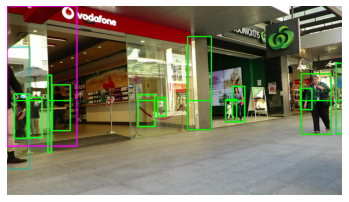

In [7]:
segmented_image = unsegmented_image.copy()
# for frame in frame_gt:
#     print(frame)
segmented_bbs = segment(segmented_image, frame_gt, new_dim=(2, 2))
# for frame in segmented_bbs:
#     print(frame)
print()
for segmented_bb in segmented_bbs[0]:
    print(segmented_bb)
    bb_left, bb_top, bb_width, bb_height = segmented_bb
    segmented_bb_tl, segmented_bb_br = getTLandBR(bb_left, bb_top, bb_width, bb_height)
    
    cv2.rectangle(segmented_image, segmented_bb_tl, segmented_bb_br, color=(0, 255, 0), thickness = 5)
#     cv2.circle(segmented_image,tl_point, 4, (0,0,255), -1)
#     cv2.circle(segmented_image,bl_point, 4, (255,0,255), -1)
#     cv2.circle(segmented_image,tr_point, 4, (0,255,255), -1)
#     cv2.circle(segmented_image,br_point, 4, (0,255,0), -1)

plt.imshow(segmented_image)
plt.axis('off')
plt.show()

In [8]:
def testRectForBB(gt_bbs, new_dim=(2, 2)):
    my_img_3 = np.zeros((100, 100, 3), dtype = "uint8")
    for gt_bb in gt_bbs:
        bb_left, bb_top, bb_width, bb_height = gt_bb
        bb_tl, bb_br = getTLandBR(bb_left, bb_top, bb_width, bb_height)

        cv2.rectangle(my_img_3, bb_tl , bb_br , color, thickness = 5)
        my_img_3 = cv2.addWeighted(my_img_3, alpha, my_img_3, 1 - alpha, 0)

    segmented_bbs = segment(my_img_3, gt_bbs, new_dim)
#     print(segmented_bbs)
    for segmented_bb in segmented_bbs[0]:
        print(segmented_bb)
        bb_left, bb_top, bb_width, bb_height = segmented_bb
        segmented_bb_tl, segmented_bb_br = getTLandBR(bb_left, bb_top, bb_width, bb_height)
        print((segmented_bb_tl, segmented_bb_br))
        print()
#         (tl_point, bl_point, tr_point, br_point) = bb_points
        
        cv2.rectangle(my_img_3, segmented_bb_tl, segmented_bb_br, color=(0,0,255), thickness = 5)
#         print(bb_points)
#         cv2.circle(my_img_3,tl_point, 4, (0,0,255), -1)
#         cv2.circle(my_img_3,bl_point, 4, (255,0,255), -1)
#         cv2.circle(my_img_3,tr_point, 4, (0,255,255), -1)
#         cv2.circle(my_img_3,br_point, 4, (0,255,0), -1)
    
    plt.imshow(my_img_3)
    plt.axis('off')
    plt.show()

(25, 25, 24, 24)
((25, 25), (49, 49))



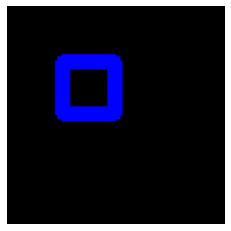

In [9]:
gt_bbs = [(25, 25, 24, 24)]
testRectForBB(gt_bbs)

(15, 25, 35, 10)
((15, 25), (50, 35))

(50, 25, 15, 10)
((50, 25), (65, 35))



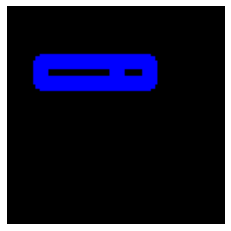

In [10]:
gt_bbs = [(15, 25, 50, 10)]
testRectForBB(gt_bbs)

(25, 25, 10, 25)
((25, 25), (35, 50))

(25, 50, 10, 25)
((25, 50), (35, 75))



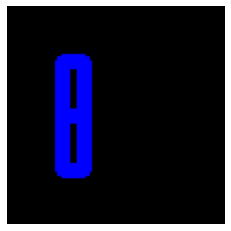

In [11]:
gt_bbs = [(25, 25, 10, 50)]
testRectForBB(gt_bbs)

(25, 60, 25, 10)
((25, 60), (50, 70))

(50, 60, 25, 10)
((50, 60), (75, 70))



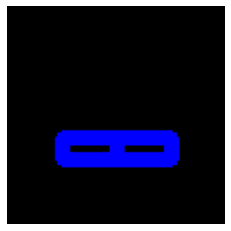

In [12]:
gt_bbs = [(25, 60, 50, 10)]
testRectForBB(gt_bbs)

(60, 25, 10, 25)
((60, 25), (70, 50))

(60, 50, 10, 25)
((60, 50), (70, 75))



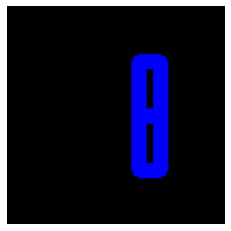

In [13]:
gt_bbs = [(60, 25, 10, 50)]
testRectForBB(gt_bbs)

topright
(50, 75) (15, 50)
bottomleft
(85, 50) (50, 25)
(15, 25, 35, 25)
((15, 25), (50, 50))

(50, 75, -35, -25)
((50, 75), (15, 50))

(85, 50, -35, -25)
((85, 50), (50, 25))

(50, 50, 35, 25)
((50, 50), (85, 75))



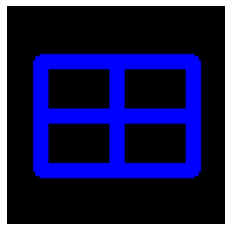

In [14]:
gt_bbs = [(15, 25, 70, 50)]
testRectForBB(gt_bbs)

topright
(33, 75) (15, 66)
bottomleft
(85, 33) (66, 25)
(15, 25, 18, 8)
((15, 25), (33, 33))

(33, 75, -18, -9)
((33, 75), (15, 66))

(85, 33, -19, -8)
((85, 33), (66, 25))

(66, 66, 19, 9)
((66, 66), (85, 75))



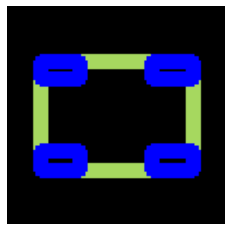

In [15]:
gt_bbs = [(15, 25, 70, 50)]
testRectForBB(gt_bbs, new_dim=(3, 3))

In [16]:
import Image

def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = list(product(range(0, h-h%d, d), range(0, w-w%d, d)))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        img.crop(box).save(out)
    
    segmented_bbs = segment(img, frame_gt, new_dim=(2, 2))
    for (segmented_bb, bb_points) in segmented_bbs:

IndentationError: expected an indented block (<ipython-input-16-3278c5acd20d>, line 15)

In [36]:
import matplotlib.pyplot as plt

stats_path = "/Users/arkwl/Downloads/stats.txt"

giou_val_loss = []
conf_val_loss = []
prob_val_loss = []
total_val_loss = []

stats_file = open(stats_path, 'r')
for stats_line in stats_file:
    individual_stats = stats_line.split(",")
    giou_val_loss.append(float(individual_stats[0].split(" ")[2]))
    conf_val_loss.append(float(individual_stats[1].split(" ")[4]))
    prob_val_loss.append(float(individual_stats[2].split(" ")[4]))
    total_val_loss.append(float(individual_stats[3].split(" ")[3]))


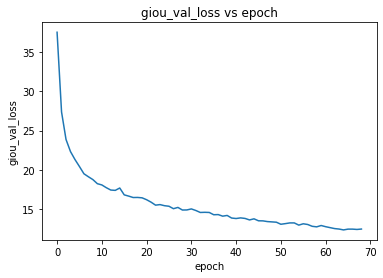

In [37]:
iterations = [i for i in range(len(giou_val_loss))]

plt.plot(iterations, giou_val_loss)
plt.title('giou_val_loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('giou_val_loss')
plt.show()

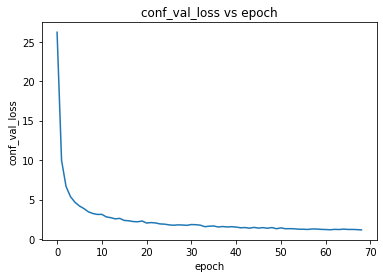

In [39]:
plt.plot(iterations, conf_val_loss)
plt.title('conf_val_loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('conf_val_loss')
plt.show()

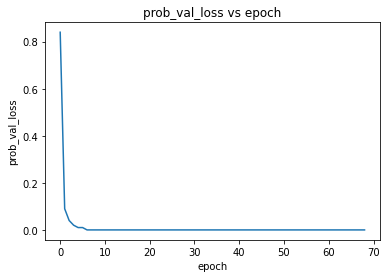

In [40]:
plt.plot(iterations, prob_val_loss)
plt.title('prob_val_loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('prob_val_loss')
plt.show()

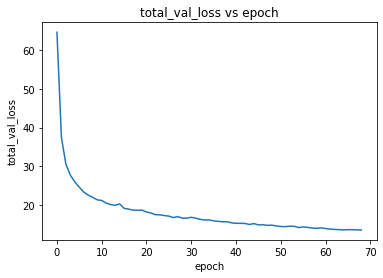

In [41]:
plt.plot(iterations, total_val_loss)
plt.title('total_val_loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('total_val_loss')
plt.show()

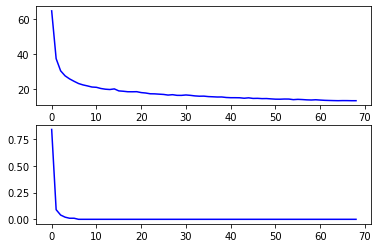

In [42]:
fig = plt.figure()
# fig.set_size_inches(30,10)
ax1 = fig.add_subplot(211)
line1 = ax1.plot(iterations, total_val_loss,color='b',label="1 row")
ax2 = fig.add_subplot(212)
line1 = ax2.plot(iterations, prob_val_loss,color='b',label="1 row")

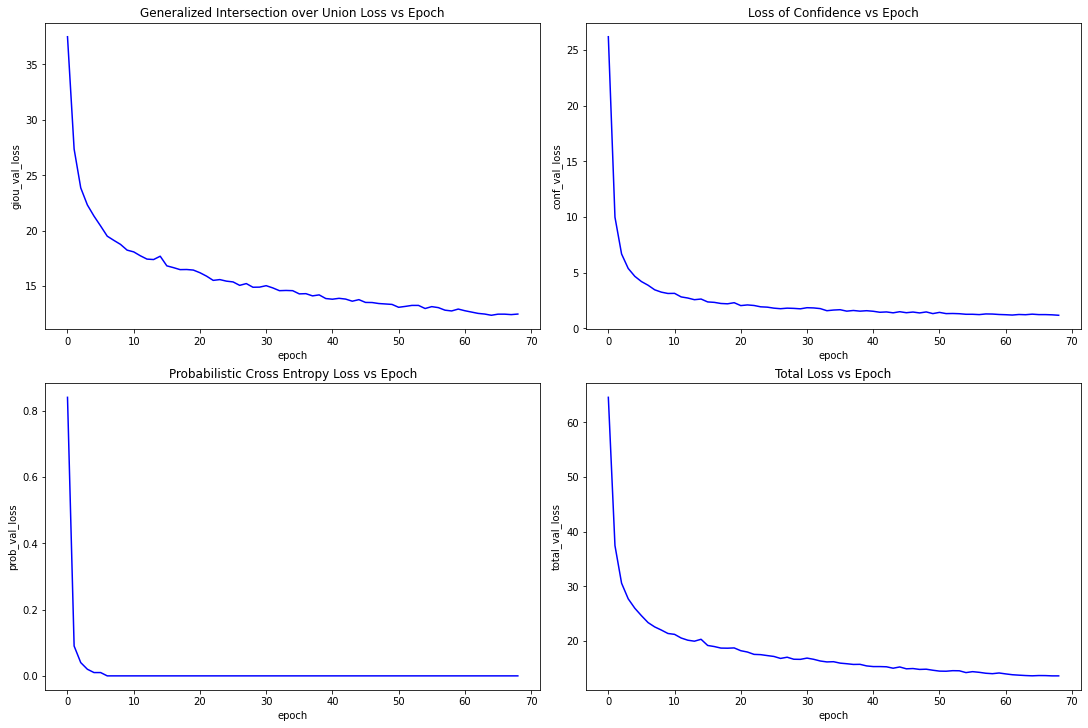

In [58]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams["figure.figsize"] = (15,10)
fig2 = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[1, 1])

f2_ax1.title.set_text('Generalized Intersection over Union Loss vs Epoch')
f2_ax2.title.set_text('Loss of Confidence vs Epoch')
f2_ax3.title.set_text('Probabilistic Cross Entropy Loss vs Epoch')
f2_ax4.title.set_text('Total Loss vs Epoch')

f2_ax1.set(xlabel="epoch", ylabel="giou_val_loss")
f2_ax2.set(xlabel="epoch", ylabel="conf_val_loss")
f2_ax3.set(xlabel="epoch", ylabel="prob_val_loss")
f2_ax4.set(xlabel="epoch", ylabel="total_val_loss")

f2_ax1.plot(iterations, giou_val_loss,color='b')
f2_ax2.plot(iterations, conf_val_loss,color='b')
f2_ax3.plot(iterations, prob_val_loss,color='b')
f2_ax4.plot(iterations, total_val_loss,color='b')